# Matrix Inversion

In this notebook, we will explore the following topics:
* Solving simultaneous equations
* Recursion
* Writing robust functions
* Good testing practise
* A real physics example

## Introduction

Many problems in physics require solving simultaneous equations. When these become large and complex, numerical routines are required.

A set of simultaneous equations can always be written in matrix form, for example, two equations in two unknowns ($x_1$ and $x_2$)

$$ax_1 + bx_2 = y_1$$
$$cx_1 + dx_2 = y_2$$

can be rewritten as

$$\left(\begin{array}{cc} a & b \\ c & d\end{array}\right)
\left(\begin{array}{c} x_1 \\ x_2 \end{array}\right) = 
\left(\begin{array}{c} y_1 \\ y_2 \end{array}\right)$$

An arbitrary set of equations is

$$Ax = y$$

where A is the matrix of coefficients, x is the vector of unknown variables $x_1$, $x_2$, ...
and b is the known vector of constants.

## Matrix Inversion

One way to solve the above equation is to multiply both sides by the inverse of A:

$$A^{-1} A x = A^{-1} y$$

giving :

$$x = A^{-1} y$$

There are many ways to find the inverse of a matrix.  You should be familiar with Cramer's rule for a general square matrix :

$$A^{-1} = \frac{1}{\det{A}}C^T$$

where C is the matrix of cofactors of A (or equivalently $C^T$ is the adjugate of A).

If we know the order (number of dimensions) of the input matrix in advance, we could do the algebra to find a formula in terms of the matrix elements. Eg we can write the function to find the inverse of a $2\times2$ matrix :

In [1]:
import numpy as np
import math

def det2x2(m):
    if m.shape[0] != 2 or m.shape[1] != 2:
        raise Exception("Non2x2Matrix")
    
    return ( m[0][0]*m[1][1] ) - ( m[0][1]*m[1][0] )

def inverse2x2(m):
    if m.shape[0] != 2 or m.shape[1] != 2:
        raise Exception("Non2x2Matrix")

    det = det2x2(m)
    tmp = np.empty([2,2])
    tmp[0][0] = m[1][1] / det
    tmp[0][1] = -1 * m[0][1] / det
    tmp[1][0] = -1 * m[1][0] / det
    tmp[1][1] = m[0][0] / det
    return tmp

Note that the first thing we do, in both functions, is to check that the function has been called with a $2\times2$ matrix.  An exception is thrown if the function is called with anything else, which will make it easier to debug problems later.

We could expand this approach to $3\times3$ and $4\times4$ matrices, but clearly that will get complicated (and error prone) pretty quickly.

Instead, if we had methods to calculate the determinant and adjugate of a general square matrix, we could just do something like :

In [2]:
def inverse(m):
    d = det(m)        
    c = adj(m)
    return np.true_divide(c,d)

First, let's look at how we would write the `det()` function.  We will use the Laplace expansion :

\begin{equation}
\det{A} = \Sigma^n_{j=1} (-1)^{i_0+j} a_{i_0j} \det{M_{i_0j}}
\end{equation}

Where $i_0$ indicates a particular row of the matrix, and $M_{ij}$ is the sub-matrix obtained by removing row i and column j of the original matrix A.

For a $3 \times 3$ matrix, this becomes :

\begin{equation*}
\begin{vmatrix}
a && b && c \\
d && e && f \\
g && h && i
\end{vmatrix}
=
a \begin{vmatrix}
e && f \\
h && i
\end{vmatrix}
-b \begin{vmatrix}
d && f \\
g && i
\end{vmatrix}
+
c \begin{vmatrix}
d && e \\
g && h
\end{vmatrix}
\end{equation*}

Note that the RHS involves the determinant of several $(n-1) \times (n-1)$ sub-matrices.  This tells us a _recursive_ algorithm can be used to find the determinant.  When finding the determinant of a $4\times4$ matrix, say, we must find determinants of $3\times3$ sub-matrices, and consequently their $2\times2$ sub-matrices.  In programming terms, this means we will write one `det()` function, which will include a call to itself. This is an extremely powerful concept in programming and numerical methods.

In addition, as we will see below, the adjugate also depends on sub-matrices.  So it also makes sense to write a function that will find the $(i,j)^{th}$ sub-matrix of a general square matrix. Again, the first thing we do is check that the argument given to the function is suitable for further processing and bail out if it isn't.

In [3]:
def submatrix(m,i,j):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    # create a new matrix
    n = m.shape[0]-1
    tmp = np.empty([n,n])
    
    # get the indices of the matrix that will be used
    tmpi = list(range(m.shape[0]))
    del tmpi[i]
    tmpj = list(range(m.shape[1]))
    del tmpj[j]
    
    for ii in range(n):
        for jj in range(n):
            tmp[ii][jj] = m[tmpi[ii]][tmpj[jj]]

    return tmp

Now we can write the `det()` function using Laplace expansion above, and taking $i_0 = 0$.

In [2]:
def det(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    if (m.shape[0]==2):
        return det2x2(m)
        
    else:
        tmp = 0
        # use 0-th row to calculate determinant
        for j in range(m.shape[0]):
            tmp = tmp + (math.pow(-1,j) * m[0][j] * det(submatrix(m,0,j)))
    
    return tmp

Next we need the adjugate function `adj()`.  The adjugate is given by :

\begin{equation}
{\rm adj}A = ((-1)^{i+j}M_{ji}
\end{equation}

Note the ordering of sub-matrix indices!  Getting this wrong is a classic way to introduce an annoying bug where the program runs normally and produces results, but they are completely incorrect.

In [5]:
def adj(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    tmp = np.empty(m.shape)
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            # note the order of indices below !
            tmp[j][i] = (math.pow(-1,i+j) * det(submatrix(m,i,j)))
    return tmp

Finally, we have everything we need for the inverse function. This time adding some protection against non-square matrices. 

In [6]:
def inverse(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    if m.shape[0]==2:
        return inverse2x2(m)
    
    d = det(m)        
    c = adj(m)
    return np.true_divide(c,d)

## Testing The Method

We can test this function with a simple matrix, for which we know the inverse. For example,

$$A = 
\pmatrix{
1 & 2 & 3 \\
1 & 0 & 0 \\
7 & 8 & 9}
$$

has the inverse

$$A^{-1} = 
\pmatrix{
0 & 1 & 0 \\
-\frac{3}{2} & -2 & \frac{1}{2} \\
\frac{4}{3} & 1 & -\frac{1}{3}
}
$$


In [108]:
a = np.array([[1,2,3],[1,0,0],[7,8,9]])
print(inverse(a))

[[ 0.          1.          0.        ]
 [-1.5        -2.          0.5       ]
 [ 1.33333333  1.         -0.33333333]]


But this is just one case, and it's one we can solve analytically.  The whole point of using a numerical method here is to solve problems we _can't_ solve analytically, so this method of testing is quite limited.

A better method is to devise a test method that works for an arbitrary matrix.  For example, we can use the identity to test if we really have found the inverse of our input matrix:

$$A A^{-1} = I$$

This kind of test is known as a 'closure test'.  It's good practise to put our test in a function which returns a boolean.

In [109]:
def test(a, atol):
    inv_a = inverse(a)
    result = inv_a @ a - np.identity(len(a[0]))
    return np.amax(result) < atol, np.amax(result)

a = np.array([[1,2,3],[1,0,0],[7,8,9]])
test(a, 1e-14)

(True, 2.220446049250313e-16)

Note that we do NOT test for exact equality of every element of $A A^{-1} - I$ with zero, since we know that rounding errors will occur due to the machine epsilon. Instead, we use a typical method which is to check for equality within some bound, specified by `atol`.  (Note that we can achieve the same thing in fewer lines using `numpy.allclose()`,  but I have written the code explicitly here for clarity).

We can extend this testing further.  Most importantly, we have only tested one case.  We should think about ways to broaden our test coverage.  For example, we could generate random matrices.

In [105]:
n_true=0
for i in range(1000):
    a = np.random.random_sample(np.identity(3).shape)
    if test(a, 1e-14)[0]:
        n_true+=1
print("Fraction of successful tests {}".format(n_true/1000))

Fraction of successful tests 0.974


You might have expected this test to produce a 100% success rate.  We can understand the result in more detail by  by looking at the closure values for a series of random matrices, as below.  Since the matrices are generated randomly, they are not necessarily well conditioned.  Some fraction will have badly behaved determinants (or have sub-matrix determinants that are badly behaved) and hence cannot be inverrted within the desired tolerance.

You can try this testing method using the `scipy.linalg.inv()` routine, instead of our version, and you will see comparable behaviour.

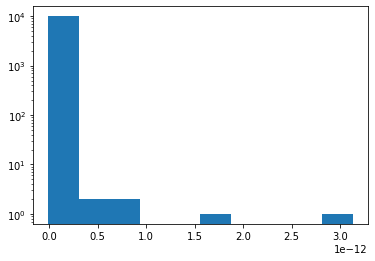

In [106]:
vals = []
for i in range(10000):
    a = np.random.random_sample(np.identity(3).shape)
    vals.append(test(a, 1e-14)[1])

plt.hist(vals)
plt.yscale('log')
plt.show()

## Physics Example

In this simple example, we will use the matrix inversion routine developed above to compute the tension in the cables of flying camera system.  The camera is suspended above a football pitch using 3 cables attached to the roof.  Each cable is fed from a motorised drum, so that the camera can be moved arounud by varying the length of the cables.  The camera has a mass of 50kg and the attachment points are all 90m from the centre of the pitch, forming an equilateral triangle in a horizontal plane.  We assume the camera is maintained at a fixed height, 5m below the attachment points.  

Ignoring the mass of the cables, we can write :
$$|T_1|\underline{n}_1 + |T_2|\underline{n}_2 + |T_3|\underline{n}_3 = mg \underline{\hat{z}}$$

where $T_i$ are the tension in each cable and $n_i$ are unit vectors pointing in the direction of each attachment point from the camera.  We can write this as :
$$\pmatrix{
n_{1,x} & n_{2,x} & n_{3,x} \\
n_{1,y} & n_{2,y} & n_{3,y} \\
n_{1,z} & n_{2,z} & n_{3,z}
}
\pmatrix{ T_1 \\ T_2 \\ T_3 }
=
\pmatrix{ 0 \\ 0 \\ -mg }
$$

Clearly, we can compute the tensions by finding the matrix in the above expression and inverting it.  First we write a function to generate the matrix from the camera position $\underline{p}$.

In [10]:
import scipy.linalg as linalg

m = 50.
g = 9.81

# attachment points
# 0,0,0 is above the centre of the pitch, in the plane of the attachments
u0 = np.array([0, 90, 0])
u1 = np.array([90*math.sqrt(3)/2, -90/2, 0])
u2 = np.array([-90*math.sqrt(3)/2, -90/2, 0])

# calculate the matrix to invert, given the 2D position of the camera in the (x,y) plane
# p is the 2D position of the camera, pp is the 3D position needed to compute the matrix
def matrix(p):
    pp = np.array([p[0], p[1], -5])
    return np.array([(u0-pp)/linalg.norm(u0-pp), (u1-pp)/linalg.norm(u1-pp), (u2-pp)/linalg.norm(u2-pp)]).T

print(matrix(np.array([0, 90])))

[[ 0.          0.499743   -0.499743  ]
 [ 0.         -0.86558026 -0.86558026]
 [ 1.          0.03205853  0.03205853]]


Now we can write the function to find the tensions from the position.  This just involves inverting the matrix and multiplying by the RHS of the equation above. Here we check this returns correct values for a few sample points.

In [23]:
def solve(p):
    a      = matrix(p)
    b      = np.array([0., 0., m*g])
    result = inverse(a) @ b
    return result

print("top point : ", solve(np.array([0, 90])))
print("centre    : ", solve(np.array([0, 0])))
print("bot mid   : ", solve(np.array([0, -45])))
print("bot left  : ", solve(np.array([-90*math.sqrt(3)/2, -45])))
print("bot right : ", solve(np.array([90*math.sqrt(3)/2, -45])))

top point :  [490.5  -0.   -0. ]
centre    :  [2947.53816769 2947.53816769 2947.53816769]
bot mid   :  [   0.         3830.92746603 3830.92746603]
bot left  :  [  0.    0.  490.5]
bot right :  [  0.  490.5  -0. ]


Now we can plot one of the tensions as a function of the position.  First, we define a function to avoid computing values outside the equilateral triangle defined by the attachment points, where we know there cannot be a physical solution.


In [110]:
def withinTriangle(p):
    a = p[1]>-45 and p[1]<90.
    b = abs(p[[0]]) < (math.sqrt(3)*(p[1]-90)/-3)
    return a and b

# set up grid of points to scan
n_points = 100
xs = np.linspace(-90*math.sqrt(3)/2, 90*math.sqrt(3)/2, n_points)
ys = np.linspace(-45, 90, n_points)

# arrays for tension results
t0s = np.zeros(shape=(n_points,n_points))
t1s = np.zeros(shape=(n_points,n_points))
t2s = np.zeros(shape=(n_points,n_points))

# now scan the grid and compute results where the method is valid
for i in range(n_points):
    for j in range(n_points):
        p = np.array([xs[i], ys[j]])
        if withinTriangle(p):
            t0s[i][j] = solve(p)[0]
            t1s[i][j] = solve(p)[1]
            t2s[i][j] = solve(p)[2]


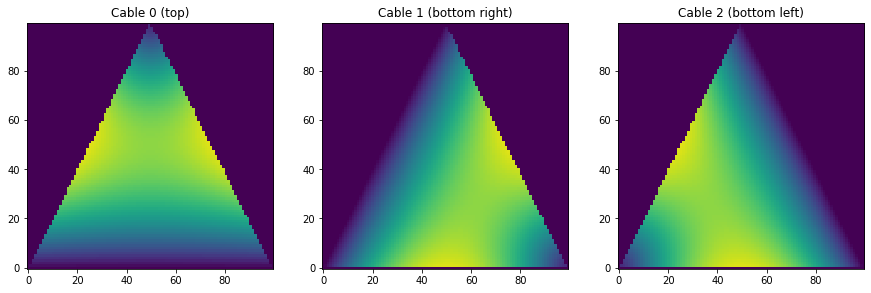

In [111]:
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
ax0.set_title("Cable 0 (top)")
ax0.imshow(t0s.T, origin='lower', cmap='viridis', vmin=0, vmax=4000)
ax1.set_title("Cable 1 (bottom right)")
ax1.imshow(t1s.T, origin='lower', cmap='viridis', vmin=0, vmax=4000)
ax2.set_title("Cable 2 (bottom left)")
ax2.imshow(t2s.T, origin='lower', cmap='viridis', vmin=0, vmax=4000)


The maximum tension in a wire is obtained when the camera is roughly half-way between the attachment point of that cable, and one of the other attachment points. At this point, the tension in the third wire is zero.

We can also find the maximum tension in each wire :

In [26]:
print("Max T cable 0 = {0:.2f}".format(np.max(t0s)))
print("Max T cable 1 = {0:.2f}".format(np.max(t1s)))
print("Max T cable 2 = {0:.2f}".format(np.max(t2s)))

Max T cable 0 = 3830.70
Max T cable 1 = 3811.81
Max T cable 2 = 3830.38


Note that each value is slightly different. Given the symmetry of the problem, we can attribute this to rounding errors.

You might want to try using one of the simultaneous equation solvers provided by `scipy.linalg` in the `solve()` method above, eg :
https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html
